# 1- Importlar:

In [1]:
import holidays as holidays
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

In [2]:
!pip install bar_chart_race

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 3.9 MB/s eta 0:00:00


In [3]:
import bar_chart_race as bcr
%matplotlib inline

# 2- Veri setini okumak:

In [4]:
df=pd.read_csv("/kaggle/input/hourly-energy-consumption/PJME_hourly.csv")

# 3- EDA:

## 3.1- Genel resmi inceleme:

In [5]:
headers = {'selector': 'th:not(.index_name)', 'props': 'background-color: #92b9ba; color: white;'}

In [6]:
def check_df(dataframe, head=10, onehot=False, time=False):    
    def highlight_cells(val):
        color = 'pink' if val == 1 else ''
        return 'background-color: {}'.format(color)

    print("___________________________________________________________________")
    print("SHAPE______________________________________________________________")
    print(" ")
    print(dataframe.shape)
    print("\n")
    print("___________________________________________________________________")
    print("TYPES______________________________________________________________")
    print(" ")
    print(dataframe.dtypes)
    print("\n")
    print("___________________________________________________________________")
    print("NA_________________________________________________________________")
    print(" ")
    print(dataframe.isnull().sum())
    print("\n")
    print("___________________________________________________________________")
    print("Nunique____________________________________________________________")
    print(" ")
    print(dataframe.nunique())
    print("\n")
    if onehot:
        print("___________________________________________________________________")
        print("HEAD_______________________________________________________________")
        print(" ")
        display(dataframe.head(10).style.set_table_styles([headers]).applymap(highlight_cells))
        print("\n")
        print("___________________________________________________________________")
        print("TAIL_______________________________________________________________")
        print(" ")
        display(dataframe.tail(10).style.set_table_styles([headers]).applymap(highlight_cells))
        print("\n")
    else:
        print("___________________________________________________________________")
        print("HEAD_______________________________________________________________")
        print(" ")
        display(dataframe.head(10).style.set_table_styles([headers]))
        print("\n")
        print("___________________________________________________________________")
        print("TAIL_______________________________________________________________")
        print(" ")
        display(dataframe.tail(10).style.set_table_styles([headers]))
        print("\n")
    print("___________________________________________________________________")
    print("QUANTILES__________________________________________________________")
    print(" ")
    display(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T.style.set_table_styles([headers]))
    print("\n")
    if time:
        print("___________________________________________________________________")
        print("PLOT_______________________________________________________________")
        print(" ")
        dataframe.plot(style='.',
                figsize=(15, 5),
                color="#92b9ba")
        plt.show()


___________________________________________________________________
SHAPE______________________________________________________________
 
(145366, 2)


___________________________________________________________________
TYPES______________________________________________________________
 
Datetime     object
PJME_MW     float64
dtype: object


___________________________________________________________________
NA_________________________________________________________________
 
Datetime    0
PJME_MW     0
dtype: int64


___________________________________________________________________
Nunique____________________________________________________________
 
Datetime    145362
PJME_MW      28441
dtype: int64


___________________________________________________________________
HEAD_______________________________________________________________
 


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.000000
1,2002-12-31 02:00:00,25147.000000
2,2002-12-31 03:00:00,24574.000000
3,2002-12-31 04:00:00,24393.000000
4,2002-12-31 05:00:00,24860.000000
5,2002-12-31 06:00:00,26222.000000
6,2002-12-31 07:00:00,28702.000000
7,2002-12-31 08:00:00,30698.000000
8,2002-12-31 09:00:00,31800.000000
9,2002-12-31 10:00:00,32359.000000




___________________________________________________________________
TAIL_______________________________________________________________
 


,Datetime,PJME_MW
145356,2018-01-01 15:00:00,38737.000000
145357,2018-01-01 16:00:00,39337.000000
145358,2018-01-01 17:00:00,41213.000000
145359,2018-01-01 18:00:00,44147.000000
145360,2018-01-01 19:00:00,44343.000000
145361,2018-01-01 20:00:00,44284.000000
145362,2018-01-01 21:00:00,43751.000000
145363,2018-01-01 22:00:00,42402.000000
145364,2018-01-01 23:00:00,40164.000000
145365,2018-01-02 00:00:00,38608.000000




___________________________________________________________________
QUANTILES__________________________________________________________
 


,0.0,0.05,0.5,0.95,0.99,1.0
PJME_MW,14544.000000,22623.000000,31421.000000,44187.750000,51156.400000,62009.000000




___________________________________________________________________
PLOT_______________________________________________________________
 


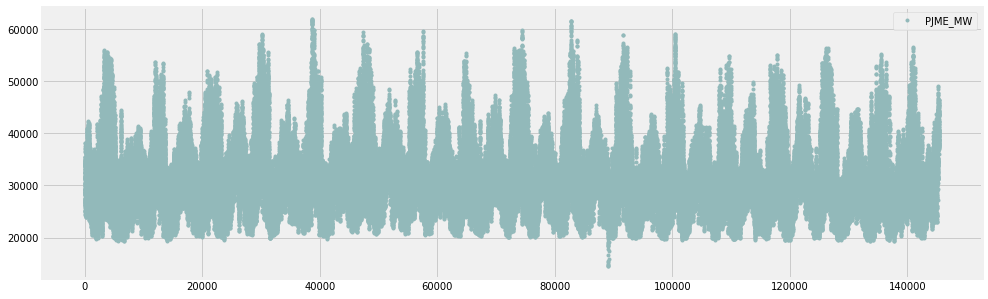

In [7]:
check_df(df,time=True)

## 3.2- Aykırı değerleri inceleme:

<AxesSubplot:title={'center':'Outliers: up limit'}>

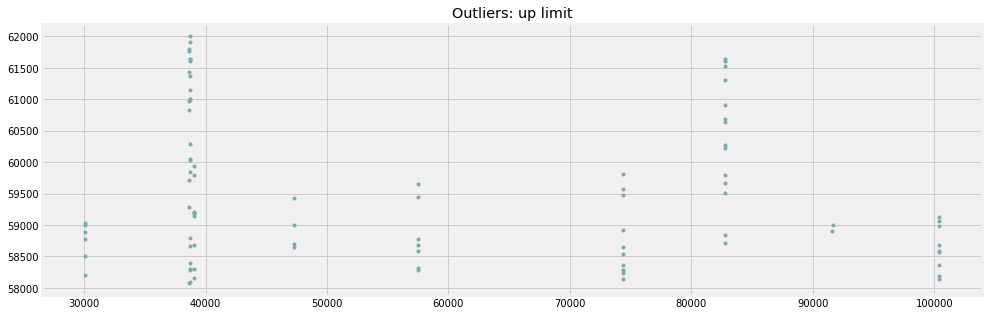

In [8]:
df.query('PJME_MW > 58_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color="#7cabad",
         title='Outliers: up limit')

<AxesSubplot:title={'center':'Outliers: low limit'}>

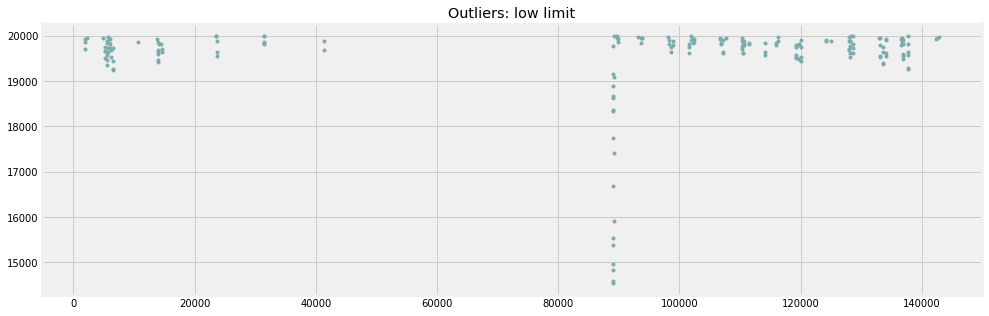

In [9]:
df.query('PJME_MW < 20_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color="#7cabad",
         title='Outliers: low limit')

# 4- Ön İşleme:

## 4.1 - Veri türünü düzeltme:

In [10]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

In [11]:
df = df.sort_values(by="Datetime", ignore_index=True)

## 4.2- Eksik tarih verilerini bulma:

In [12]:
# eksik tarih verilerini bulma:
min_dt = df.Datetime.min() # ilk tarih

In [13]:
min_dt

Timestamp('2002-01-01 01:00:00')

In [14]:
max_dt = df.Datetime.max() # son tarih

In [15]:
max_dt

Timestamp('2018-08-03 00:00:00')

In [16]:
dt_range = pd.date_range(min_dt, max_dt, freq='H') # ilk ve son tarih aralığında olması gereken tüm zaman verileri

In [17]:
dt_range = pd.DataFrame(data=dt_range, columns=["Datetime"])

In [18]:
missing_dts = pd.DataFrame(dt_range.merge(df,
                                          indicator=True,
                                          how='left',
                                          on="Datetime").loc[lambda x : x['_merge']!='both']).reset_index().drop(['index', '_merge'], axis=1) # eksik olan tarihler

In [19]:
print("There are {n} missing dates".format(n=len(missing_dts)))

There are 30 missing dates


## 4.3- Eksik tarih verilerini veri setine ekleme ve doldurma:

In [20]:
# Eksik tarihlerin eklenmesi:
df = pd.concat([df,missing_dts], axis=0, ignore_index=True) #eksik tarihleri ana dataframemime ekliyorum

In [21]:
del dt_range

In [22]:
del missing_dts

In [23]:
# eksik değerlerimizi bi inceleyelim:
display(df[df.isnull().any(axis=1)].style.set_table_styles([headers]))


,Datetime,PJME_MW
145366,2002-04-07 03:00:00,nan
145367,2002-10-27 02:00:00,nan
145368,2003-04-06 03:00:00,nan
145369,2003-10-26 02:00:00,nan
145370,2004-04-04 03:00:00,nan
145371,2004-10-31 02:00:00,nan
145372,2005-04-03 03:00:00,nan
145373,2005-10-30 02:00:00,nan
145374,2006-04-02 03:00:00,nan
145375,2006-10-29 02:00:00,nan


Eksik PJM_Load_MW değerlerinin doldurulması:

In [24]:
df = df.set_index('Datetime')

In [25]:
df.index = pd.to_datetime(df.index)

In [26]:
df = df.sort_index()

In [27]:
df.interpolate(limit_direction="both",inplace=True)

Kontrol ediyoruz:

___________________________________________________________________
SHAPE______________________________________________________________
 
(145396, 1)


___________________________________________________________________
TYPES______________________________________________________________
 
PJME_MW    float64
dtype: object


___________________________________________________________________
NA_________________________________________________________________
 
PJME_MW    0
dtype: int64


___________________________________________________________________
Nunique____________________________________________________________
 
PJME_MW    28455
dtype: int64


___________________________________________________________________
HEAD_______________________________________________________________
 


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.000000
2002-01-01 02:00:00,29265.000000
2002-01-01 03:00:00,28357.000000
2002-01-01 04:00:00,27899.000000
2002-01-01 05:00:00,28057.000000
2002-01-01 06:00:00,28654.000000
2002-01-01 07:00:00,29308.000000
2002-01-01 08:00:00,29595.000000
2002-01-01 09:00:00,29943.000000




___________________________________________________________________
TAIL_______________________________________________________________
 


,PJME_MW
Datetime,
2018-08-02 15:00:00,47154.000000
2018-08-02 16:00:00,46989.000000
2018-08-02 17:00:00,46816.000000
2018-08-02 18:00:00,46760.000000
2018-08-02 19:00:00,45641.000000
2018-08-02 20:00:00,44057.000000
2018-08-02 21:00:00,43256.000000
2018-08-02 22:00:00,41552.000000
2018-08-02 23:00:00,38500.000000




___________________________________________________________________
QUANTILES__________________________________________________________
 


,0.0,0.05,0.5,0.95,0.99,1.0
PJME_MW,14544.000000,22622.000000,31420.000000,44187.000000,51155.200000,62009.000000




___________________________________________________________________
PLOT_______________________________________________________________
 


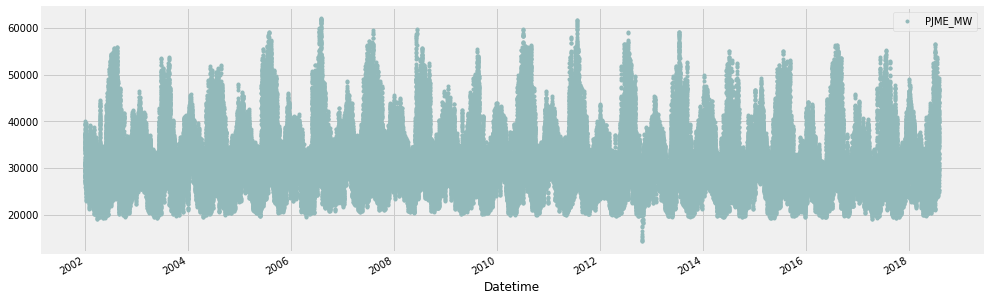

In [28]:
check_df(df,time=True)

## 4.4- Aykırı verileri baskılama:

In [29]:
df['month'] = df.index.month

In [30]:
df=df.reset_index()

In [31]:
for i in range(len(df)):
    if df.loc[i,"PJME_MW"]< 19100:
        df.loc[i,"PJME_MW"] = 19100
    elif df.loc[i,"PJME_MW"]> 60100:
        df.loc[i,"PJME_MW"] = 60100
        

En uç değerleri baskıladım. Bu baskılama işlemim 17 yıllık bir veri setinin sadece en uç 3 ayı için yapılmış olduğunu grafikteki aykırılıklara bakarak görebiliriz. 
Şimdi veri setinin genelinde aylara göre aykırı değer işlemi gerçekleştireceğim. 

In [32]:
def groupby_thresholds(df, col_name1,col_name2, q1=0.25, q3=0.75):
    df["lower"] = df.groupby(col_name1)[col_name2].transform(lambda x: x.quantile(q1))
    df["upper"] = df.groupby(col_name1)[col_name2].transform(lambda x: x.quantile(q3))
    df["lower"] = df.lower.astype(np.float16)
    df["upper"] = df.upper.astype(np.float16)
    df["interquantile_range"] = df["upper"] - df["lower"]
    df["uplimit"]= df["upper"] + 1.5 * df["interquantile_range"]
    df["lowlimit"]= df["lower"] - 1.5 * df["interquantile_range"]
    df["uplimit"] = df.uplimit.astype(np.float16)
    df["lowlimit"] = df.lowlimit.astype(np.float16)
    df.drop(['lower', 'upper', 'interquantile_range'], axis=1, inplace=True)
    print("işlem tamamlandı")
    


In [33]:
groupby_thresholds(df,col_name1=["month"],col_name2=["PJME_MW"])

işlem tamamlandı


In [34]:
df=df.reset_index()

In [35]:
for i in range(len(df)):
    if df.loc[i,"PJME_MW"]> df.loc[i, "uplimit"]:
        df.loc[i,"PJME_MW"] = df.loc[i, "uplimit"]

ileride kullanacağım fonksiyonda zaten month ekleyeceğim için çıkarıyorum. fonksiyonumu bozmak istemiyorum :d

In [36]:
df.drop(['index','month','uplimit', 'lowlimit'], axis=1, inplace=True)

In [37]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

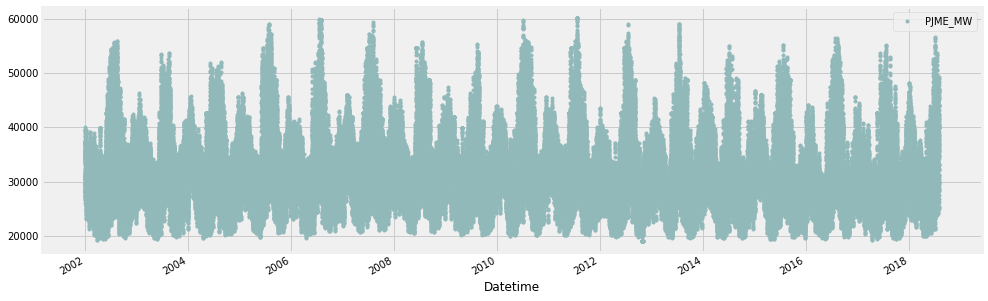

In [38]:
df.plot(style='.',
               figsize=(15, 5),
               color="#92b9ba")
plt.show()

# 5- Özellik mühendisliği:

Yıl, ay, gün ve saat gibi değişkenler oluşturma:

In [39]:

# tarih değişkenleri oluşturma
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [40]:
df = create_features(df)

Tatil değişkeni ekleme:

In [41]:
def create_holiday(df, ulke="US"):
    holiday_list = []
    year = df.index.year.unique()
    year = year.values
    year = year.tolist()
    for y in year:
        for holiday in holidays.CountryHoliday(country= ulke, years=[y]).items():
            holiday_list.append(holiday)
        holidays_df = pd.DataFrame(holiday_list, columns=["Datetime", "Holiday"])
        holidays_df= holidays_df.set_index('Datetime')
    return holidays_df

In [42]:
holiday_df= create_holiday(df, ulke="US")

In [43]:
display(holiday_df.head(10).style.set_table_styles([headers]))

,Holiday
Datetime,
2002-01-01,New Year's Day
2002-01-21,Martin Luther King Jr. Day
2002-02-18,Washington's Birthday
2002-05-27,Memorial Day
2002-07-04,Independence Day
2002-09-02,Labor Day
2002-10-14,Columbus Day
2002-11-11,Veterans Day
2002-11-28,Thanksgiving


In [44]:
holiday_df = holiday_df.reset_index()

normal veri setimiz ile birleştirdiğimizde sadece 00.00a denk gelen saatlerimiz holiday olurken günün diğer saatleri nan dönmesin diye aşağıdaki işlemleri yapıyorum:

In [45]:
newholiday = pd.DataFrame(columns=['Holiday'])
for i in range(len(holiday_df['Datetime'])):
    newholiday=pd.concat([newholiday, (pd.date_range(holiday_df.loc[i,'Datetime'], periods=24, freq='H').to_frame(index=False))])

In [46]:
newholiday=newholiday.rename(columns = {0:'Datetime'})

In [47]:
newholiday = newholiday.fillna(1)

In [48]:
display(newholiday.head(10).style.set_table_styles([headers]))

,Datetime,Holiday
0,2002-01-01 00:00:00,1
1,2002-01-01 01:00:00,1
2,2002-01-01 02:00:00,1
3,2002-01-01 03:00:00,1
4,2002-01-01 04:00:00,1
5,2002-01-01 05:00:00,1
6,2002-01-01 06:00:00,1
7,2002-01-01 07:00:00,1
8,2002-01-01 08:00:00,1
9,2002-01-01 09:00:00,1


In [49]:
newholiday = newholiday.set_index('Datetime')

In [50]:
newholiday.index = pd.to_datetime(newholiday.index)

artık tatillerimi normal veri setime ekleyebilirim

In [51]:
df= df.join(newholiday)

In [52]:
df = df.sort_index()

In [53]:
df = df.fillna(0)

artık gerek duymadığımız veri setlerini siliyorum:

In [54]:
del holiday_df

In [55]:
del newholiday

son halini kontrol edelim:

In [56]:
check_df(df)

___________________________________________________________________
SHAPE______________________________________________________________
 
(145396, 10)


___________________________________________________________________
TYPES______________________________________________________________
 
PJME_MW       float64
hour            int64
dayofweek       int64
quarter         int64
month           int64
year            int64
dayofyear       int64
dayofmonth      int64
weekofyear     UInt32
Holiday       float64
dtype: object


___________________________________________________________________
NA_________________________________________________________________
 
PJME_MW       0
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
Holiday       0
dtype: int64


___________________________________________________________________
Nunique____________________________________________________________
 
PJME_MW       28181
ho

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Holiday
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.000000,1,1,1,1,2002,1,1,1,1.000000
2002-01-01 02:00:00,29265.000000,2,1,1,1,2002,1,1,1,1.000000
2002-01-01 03:00:00,28357.000000,3,1,1,1,2002,1,1,1,1.000000
2002-01-01 04:00:00,27899.000000,4,1,1,1,2002,1,1,1,1.000000
2002-01-01 05:00:00,28057.000000,5,1,1,1,2002,1,1,1,1.000000
2002-01-01 06:00:00,28654.000000,6,1,1,1,2002,1,1,1,1.000000
2002-01-01 07:00:00,29308.000000,7,1,1,1,2002,1,1,1,1.000000
2002-01-01 08:00:00,29595.000000,8,1,1,1,2002,1,1,1,1.000000
2002-01-01 09:00:00,29943.000000,9,1,1,1,2002,1,1,1,1.000000




___________________________________________________________________
TAIL_______________________________________________________________
 


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Holiday
Datetime,,,,,,,,,,
2018-08-02 15:00:00,47154.000000,15,3,3,8,2018,214,2,31,0.000000
2018-08-02 16:00:00,46989.000000,16,3,3,8,2018,214,2,31,0.000000
2018-08-02 17:00:00,46816.000000,17,3,3,8,2018,214,2,31,0.000000
2018-08-02 18:00:00,46760.000000,18,3,3,8,2018,214,2,31,0.000000
2018-08-02 19:00:00,45641.000000,19,3,3,8,2018,214,2,31,0.000000
2018-08-02 20:00:00,44057.000000,20,3,3,8,2018,214,2,31,0.000000
2018-08-02 21:00:00,43256.000000,21,3,3,8,2018,214,2,31,0.000000
2018-08-02 22:00:00,41552.000000,22,3,3,8,2018,214,2,31,0.000000
2018-08-02 23:00:00,38500.000000,23,3,3,8,2018,214,2,31,0.000000




___________________________________________________________________
QUANTILES__________________________________________________________
 


,0.0,0.05,0.5,0.95,0.99,1.0
PJME_MW,19100.000000,22622.000000,31420.000000,44088.250000,51011.300000,60100.000000
hour,0.000000,1.000000,11.000000,22.000000,23.000000,23.000000
dayofweek,0.000000,0.000000,3.000000,6.000000,6.000000,6.000000
quarter,1.000000,1.000000,2.000000,4.000000,4.000000,4.000000
month,1.000000,1.000000,6.000000,12.000000,12.000000,12.000000
year,2002.000000,2002.000000,2010.000000,2017.000000,2018.000000,2018.000000
dayofyear,1.000000,18.000000,179.000000,347.000000,362.000000,366.000000
dayofmonth,1.000000,2.000000,16.000000,29.000000,31.000000,31.000000
weekofyear,1,3,26,50,52,53
Holiday,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000


# 6- Visualize our Feature / Target Relationship

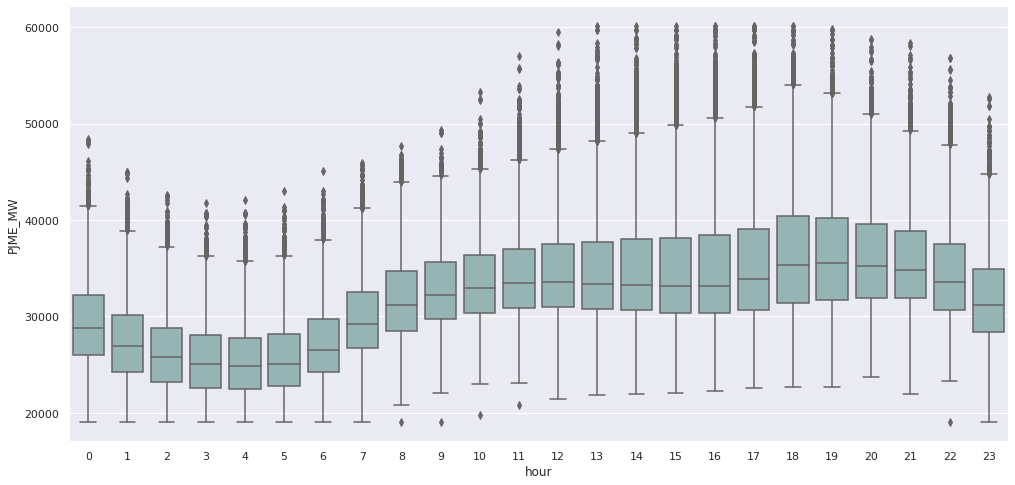

In [57]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW', color="#92b9ba")
plt.show()

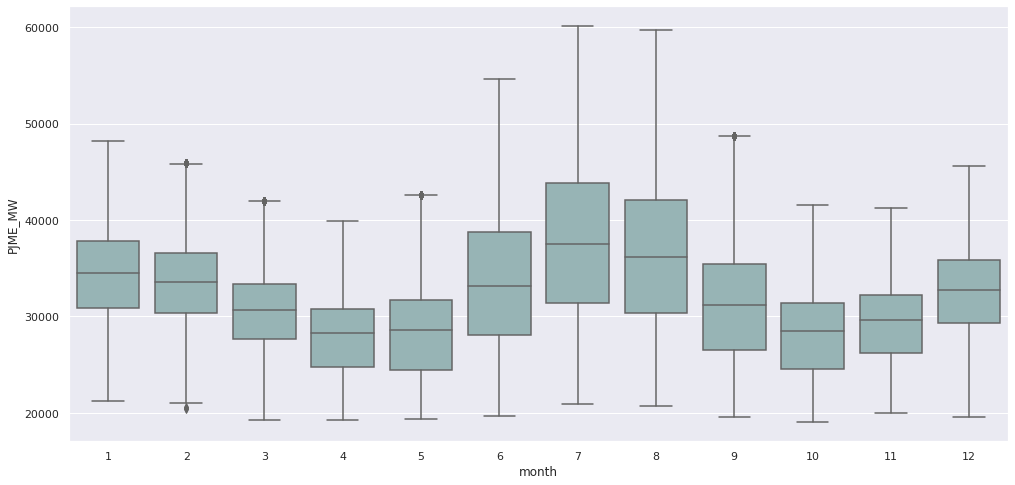

In [58]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='month', y='PJME_MW',color="#92b9ba")
plt.show()

# Create our Model

In [59]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',"dayofmonth","weekofyear","Holiday"]
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

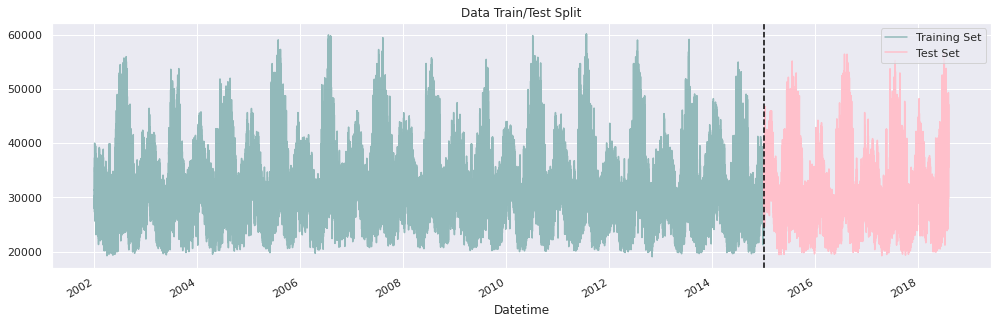

In [60]:
fig, ax = plt.subplots(figsize=(15, 5))
train.PJME_MW.plot(ax=ax, color="#92b9ba", label='Training Set', title='Data Train/Test Split')
test.PJME_MW.plot(ax=ax, color="#ffc0cb", label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()